In [2]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
from scipy.signal import argrelextrema, argrelmax, argrelmin


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 1 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 1, 'figure.dpi': 300})


In [3]:
from minizinc import Instance, Model, Solver, Status as mzStatus
import nest_asyncio
nest_asyncio.apply()

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap

In [5]:

def call_mzn_model(model_name,model_params):
    with open(f'pars-{model_name}.dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=2))

    # print('Model params:', model_params)

    mzn_model = Model(f'{model_name}.mzn')
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzn_model)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    return result


In [6]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = 2, .2
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

In [7]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716


In [8]:
odf['boL'] = odf[['open', 'close']].min(axis=1)
odf['boH'] = odf[['open', 'close']].max(axis=1)
odf['cadir'] = 1 - 2 *(odf.close < odf.open)
odf['dirF1'] = odf.cadir.shift(-1).ffill().astype(int)
###
odf['cadir'] = 1 - 2*(odf.close < odf.open).astype(int)
# wdf
mzn_res = call_mzn_model('last-such', {'markers': odf.cadir.values.tolist()})
odf['n_prev'] = mzn_res['prev']

odf['f_6_close_max'] = odf.close.rolling(6).max().shift(-6)
# roll18 = odf.rolling(18)
# odf['l_18_std']

###
odf.head(5)


,timestamp,open,high,low,close,volume,boL,boH,cadir,dirF1,n_prev,f_6_close_max
dtime,,,,,,,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865,4261.48,4349.99,1,1,0,4427.30
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882,4333.32,4427.30,1,-1,1,4352.34
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001,4352.34,4436.06,-1,-1,0,4340.31
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716,4325.23,4352.33,-1,-1,-1,4340.31
2017-08-17 20:00:00,1503000000000,4307.56,4369.69,4258.56,4285.08,249.769913,4285.08,4307.56,-1,1,-2,4340.31


In [9]:

laRoll = wdf.rolling(window=3)
(laRoll.boL.std() / wdf.close).describe()

AttributeError: 'NoneType' object has no attribute 'rolling'

In [39]:
def add_indicators(wdf, lag, xOrd):
    ###
    laRoll = wdf.rolling(window=lag)
    wdf[f'laMean'] = laRoll.boL.mean()#.bfill()
    wdf[f'laMin'] = laRoll.boL.min()#.bfill()
    wdf[f'laMax'] = laRoll.boL.max()#.bfill()
    wdf[f'laStd'] = laRoll.boL.std() 
    wdf[f'laZScore'] = (wdf.close - wdf.laMean) / wdf.laStd #.bfill()

    laRoll = wdf.rolling(window=lag)
    wdf[f'wd2laMeanP'] = wdf.low.divide(wdf.laMean).apply(np.log) * (wdf.laMean > wdf.low)
    wdf[f'wdSum'] = laRoll.wd2laMeanP.sum()
    wdf[f'wdMin'] = laRoll.wd2laMeanP.min()

    wdf[f'l_18_min'] = wdf.close.rolling(18).min()
    wdf[f'l_18_max'] = wdf.close.rolling(18).max()
    wdf[f'l_12_min'] = wdf.close.rolling(12).min()
    wdf[f'l_12_max'] = wdf.close.rolling(12).max()
    ###
    # for local maxima
    iUps = argrelextrema(wdf.close.values, np.greater, order=xOrd)
    iDns = argrelextrema(wdf.close.values, np.less, order=xOrd)
    ixUps = wdf.index[iUps]
    ixDns = wdf.index[iDns]
    ###
    return wdf


In [40]:
# import logging

# logging.basicConfig(filename="minizinc-python.log", level=logging.DEBUG)
wdf = None
sig = None
def printer(ws, xOrd, laZScore, par_wick):
    global wdf, sig
    wstart = ws * wlen
    wend = wstart + wlen
    wdf = odf.iloc[wstart:wend].copy()

    wdf = add_indicators(wdf, lag=4, xOrd=xOrd)
    sig = ((wdf.laZScore < laZScore) & (wdf.cadir == -1))

    # isig = wdf[sig].index
    
    ###
    fig = plt.figure(figsize=(15,5))
    # fig, (ax1,ax2) = plt.subplots(2,1, height_ratios=[2,1], sharex=True)
    plt.tight_layout()
    ax1,ax2 = fig.subplots(2,1, height_ratios=[2,1], sharex=True)
    wdf.close.plot(ax=ax1, lw=0.5)
    for i in wdf.index[sig]: 
        for ax in [ax1]:
            ax.axvline(i, lw=2, alpha=0.2)
    wdf.wdSum.plot(ax=ax2, secondary_y=True, legend='wdSum')
    wdf.wdMin.plot(ax=ax2, legend=True)
    wdf.laZScore.plot(ax=ax1, secondary_y=True)
    # ax1.set_label(True)
    # ax1.scatter(ixUps, wdf.close[ixUps], c='r', alpha=0.3, s=50)
    # ax1.scatter(ixDns, wdf.close[ixDns], c='g', alpha=0.3, s=50)
    # ax2.plot(wdf.index,wdf.wdSum, c='b')
    plot_candles(wdf,ax=ax1)
    
    # ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)
wlen = 2000
x = interact(printer, 
         ws=IntSlider(min=0, max=odf.shape[0] // wlen, step=1, value=50, description='wn'), 
         xOrd=IntSlider(min=1,max=15,value=6, description='XOrd'),
         laZScore=FloatText(min=0.,max=0.10,step=0.001, value=0.0005, description='laZScore'), 
         par_wick=FloatText(min=0.,max=0.05,step=0.001, description='wick'))

interactive(children=(IntSlider(value=6, description='wn', max=6), IntSlider(value=6, description='XOrd', max=…

In [29]:
# wdf.index[sig]
# laRoll

### Naive Bayes

In [30]:

# wdf

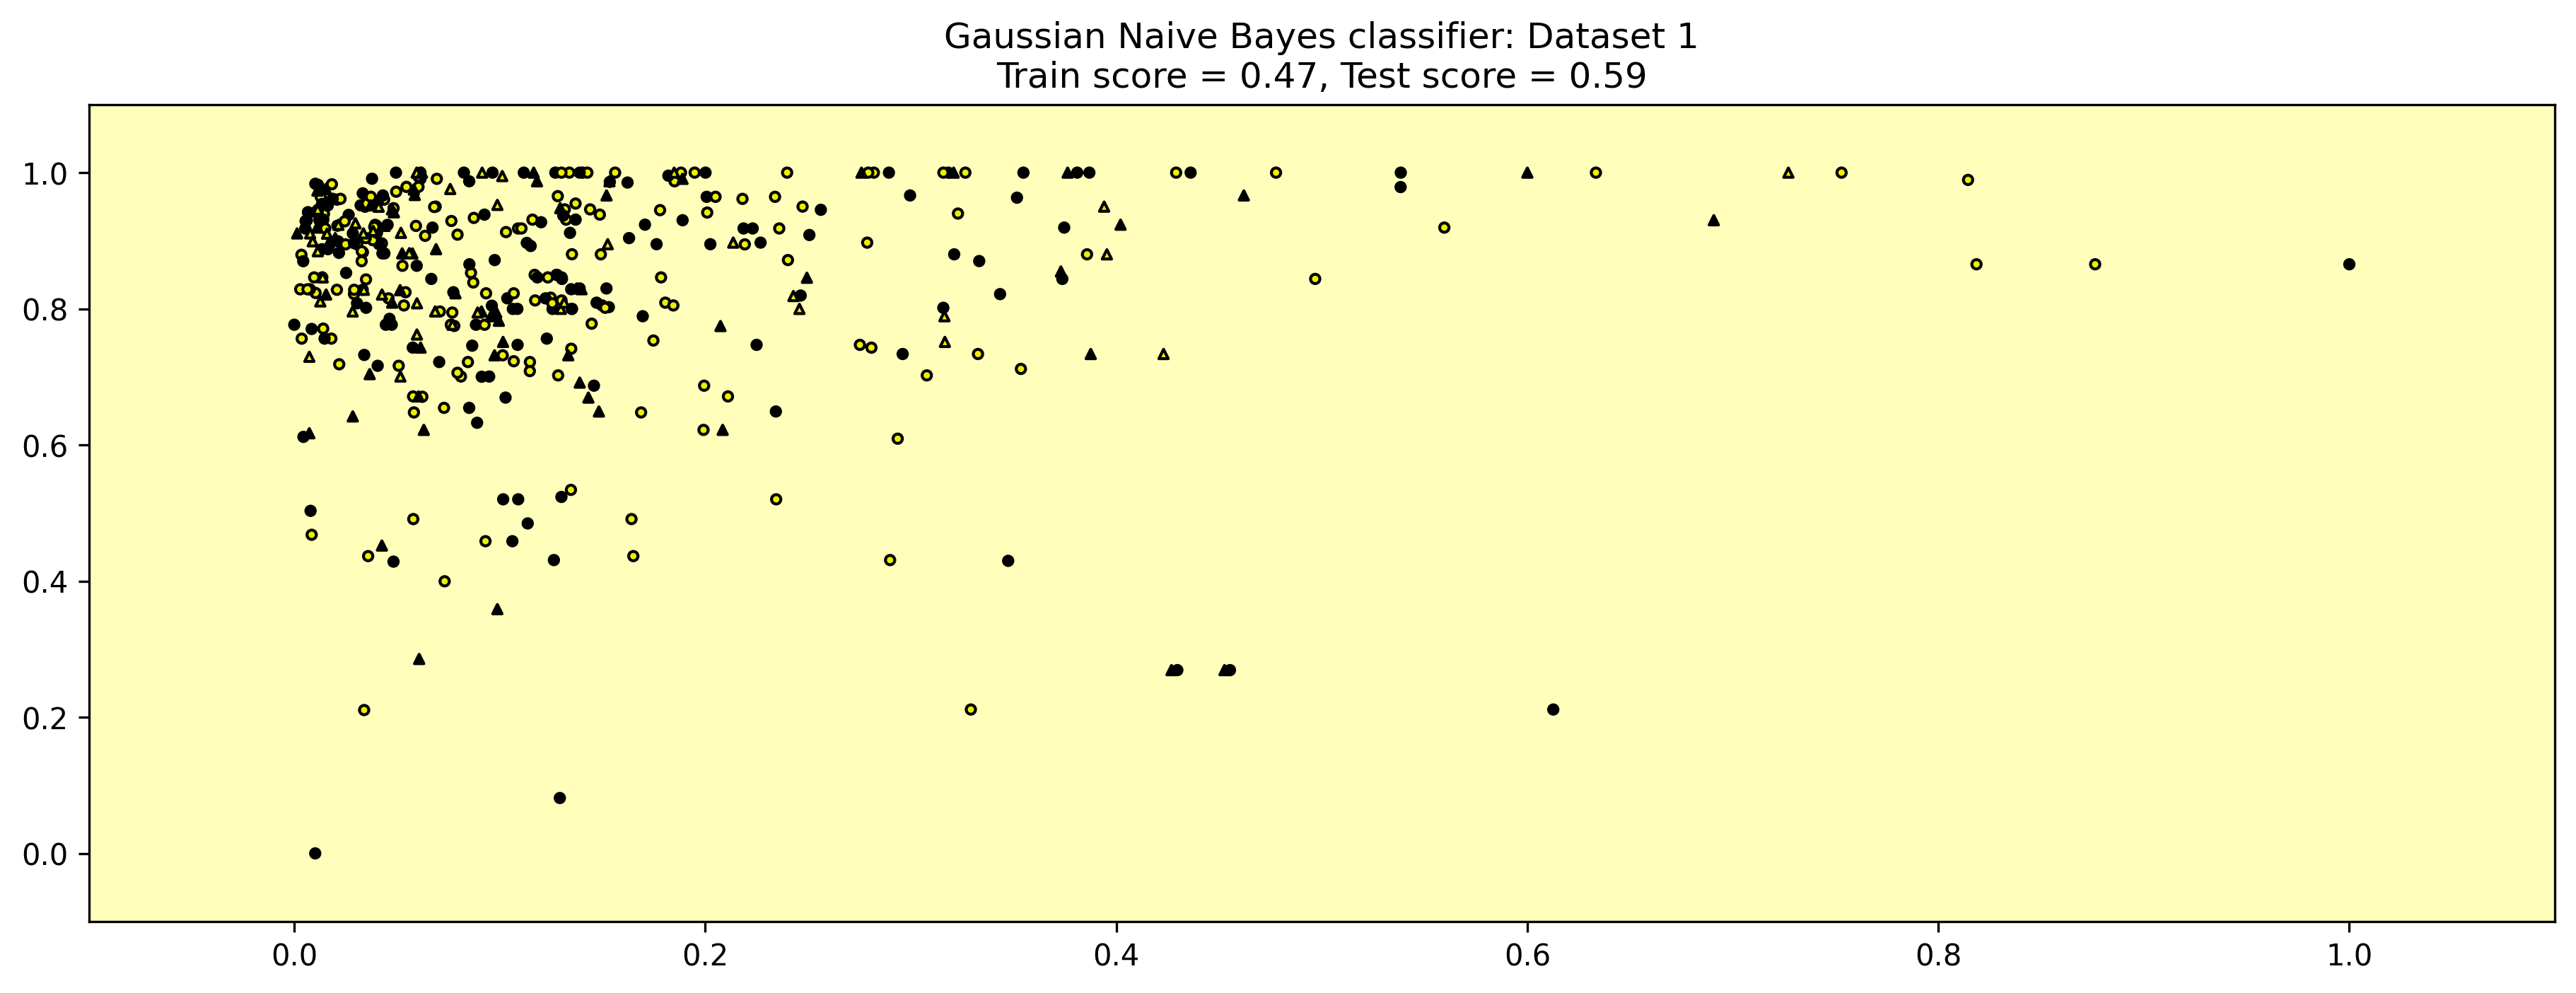

In [41]:
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier

adf = wdf[wdf.laZScore >= 0.0005 ].dropna()
X_wdf = adf[['laStd','wdMin']].values
y_wdf = adf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_trainS, y_train, X_testS, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1', gkwargs={'figsize':(15,5)})

### Gradient-Boosted Decision Tree

In [42]:
from sklearn.ensemble import GradientBoostingClassifier


adf = wdf[wdf.laZScore >= 0.0005 ].dropna()
X_wdf = adf[['laStd', 'wdSum']].values
y_wdf = adf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

# clf = GradientBoostingClassifier(random_state = 0)
# clf.fit(X_train, y_train)

# print('(learning_rate=0.1, max_depth=3)')
# print('Accuracy of GBDT classifier on training set: {:.2f}'
#      .format(clf.score(X_train, y_train)))
# print('Accuracy of GBDT classifier on test set: {:.2f}\n'
#      .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, random_state = 0)
clf.fit(X_train, y_train)

print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.50


### Neural Nets Classifier

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


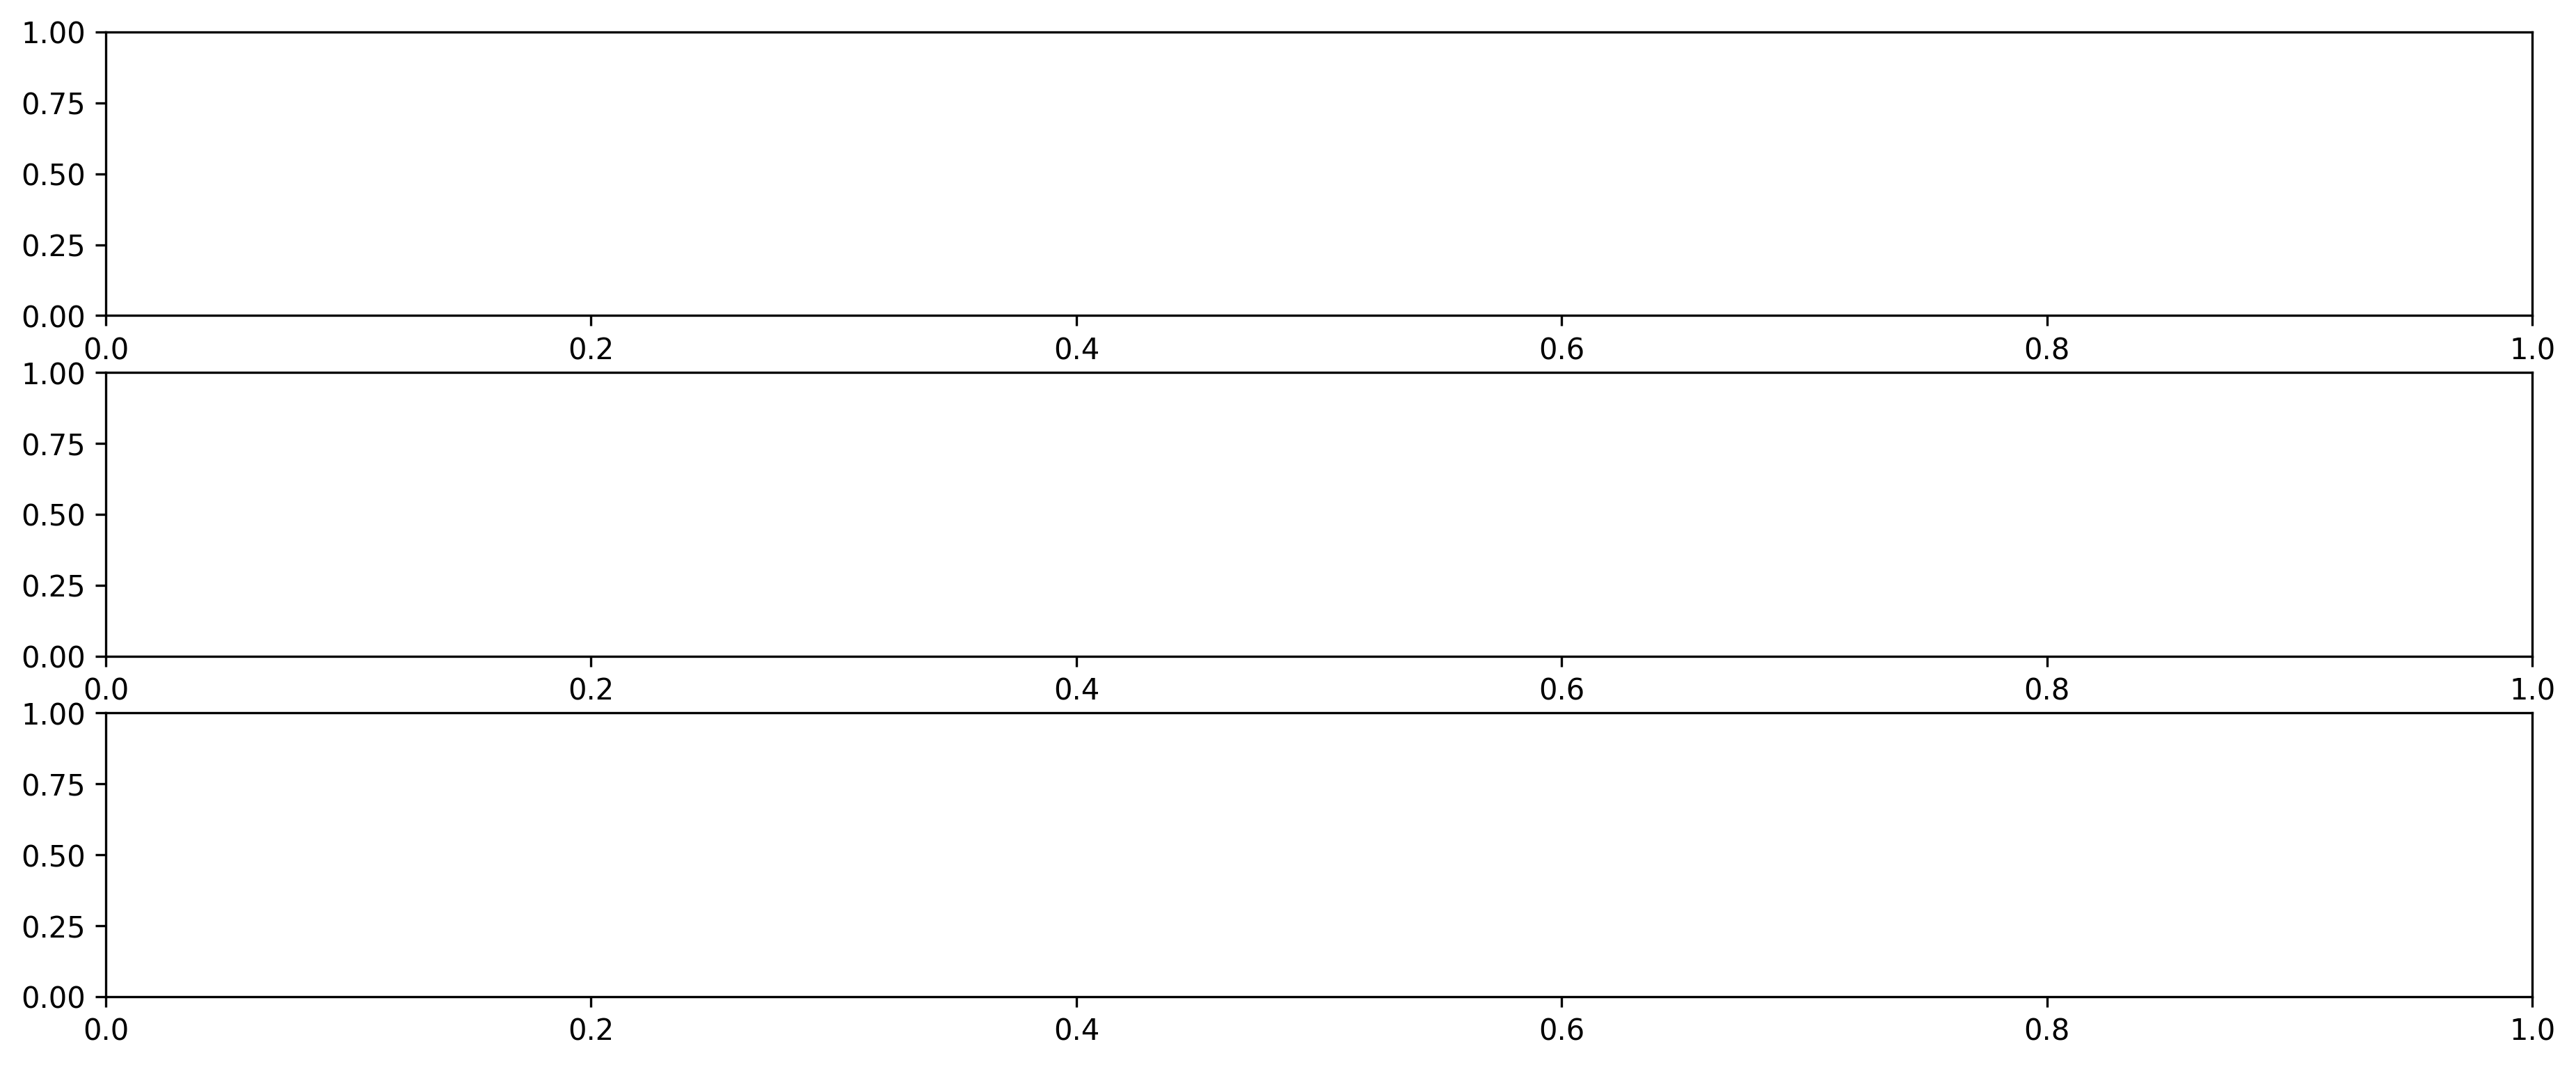

In [43]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

wdf = wdf.dropna()
X_wdf = wdf[['laStd','wdMin', 'n_prev']].values
y_wdf = wdf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

fig, subaxes = plt.subplots(3, 1, figsize=(15,6))

for units, axis in zip([10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units]* 2, solver='lbfgs',
                         random_state = 0).fit(X_trainS, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    # plot_class_regions_for_classifier_subplot(nnclf, X_trainS, y_train,
    #                                          X_testS, y_test, title, axis)
    # plt.tight_layout()

In [46]:

import itertools

list(itertools.product([2,3,4,5], [10,15,20,30,50]))

[(2, 10),
 (2, 15),
 (2, 20),
 (2, 30),
 (2, 50),
 (3, 10),
 (3, 15),
 (3, 20),
 (3, 30),
 (3, 50),
 (4, 10),
 (4, 15),
 (4, 20),
 (4, 30),
 (4, 50),
 (5, 10),
 (5, 15),
 (5, 20),
 (5, 30),
 (5, 50)]

In [86]:

df_test_results = pd.DataFrame(columns=['layers', 'units', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
df_test_results.set_index(['layers', 'units'])
df_test_results

,layers,units,tp,fp,tn,fn,precision,recall


In [191]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import itertools

wdf = wdf.dropna()
X_wdf = wdf[['open', 'high', 'low', 'close', 'volume', 'boL', 'boH',
       'cadir', 'n_prev', 'f_6_close_max', 'laMean', 'laMin', 'laMax',
       'laStd', 'laZScore', 'wd2laMeanP', 'wdSum', 'wdMin', 'l_18_min',
       'l_18_max', 'l_12_min', 'l_12_max']].values

# y_wdf = wdf.dirF1.values
fu_N = 2
y_wdf = (wdf.close.rolling(fu_N).max().shift(-fu_N).divide(wdf.close).apply(np.log) > 0.015).fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

# df_test_results = pd.DataFrame(columns=['layers', 'units', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
# df_train_results = pd.DataFrame(columns=['layers', 'units', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
test_scores_rows = []
train_conf_mat = None
for layers,units in itertools.product([2,3,5,8,10,12,13], [10,15,20,30,40,60,80,100, 150]):
    clf = MLPClassifier(hidden_layer_sizes = [units]* layers, solver='adam',
                            learning_rate='adaptive',
                            random_state = 0, max_iter=200
                         ).fit(X_trainS, y_train)
    
    train_score = clf.score(X_trainS, y_train)
    test_score  = clf.score(X_testS, y_test)
    print('================================================================')
    print(f'Neural net classifier, {layers} layer, {units} units')
    print(f"Train score = {train_score:.2f}, Test score = {test_score:.2f}")
    print(f'---------------------------------------------------------------')

    y_train_pred = clf.predict(X_trainS)
    train_conf_mat = confusion_matrix(y_train, y_train_pred)
    print(f'Training confusion_matrix: \n{train_conf_mat}')
    # train_precision = precision_score(y_train, y_train_pred)
    # train_recall = recall_score(y_train, y_train_pred)


    # print(f'Train precision = {round(train_precision,2)}, recall = {round(train_recall,2)}')
     
    print(f'----------')
    y_test_pred = clf.predict(X_testS)
    test_conf_mat = confusion_matrix(y_test, y_test_pred)
    print(f'Testing confusion matrix: \n{test_conf_mat}')
    # test_precision = precision_score(y_test, y_test_pred)
    # test_recall = recall_score(y_test, y_test_pred)
    # print(f'Test precision = {round(test_precision,2)}, recall = {round(test_recall,2)}')

    # df_train_results.append({'layers': layers, 'units': units, 'tp': tr_tp, 'fn': tr_fn, 'tn': tr_tn, 'fp': tr_fp})
    # test_scores_rows.append({'layers': layers, 'units': units, 'tp': tst_tp, 'fn': tst_fn, 'tn': tst_tn, 'fp': tst_fp})

    test_scores_rows.append({'layers': layers, 'units': units, 'test_conf_mat': test_conf_mat, 'train_conf_mat': train_conf_mat})


    # df_test_scores.loc([layers, units]) = {'tp': tst_tp, 'fn': tst_fn, 'tn': tst_tn, 'fp': tst_fp})

#     break
    # plot_class_regions_for_classifier_subplot(nnclf, X_trainS, y_train,
                                            #  X_testS, y_test, title, axis)
    # plt.tight_layout()

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 10 units
Train score = 0.86, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[422   0]
 [ 67   0]]
----------
Testing confusion matrix: [[147   0]
 [ 17   0]]
Neural net classifier, 2 layer, 15 units
Train score = 0.87, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[418   4]
 [ 60   7]]
----------
Testing confusion matrix: [[145   2]
 [ 17   0]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 20 units
Train score = 0.87, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[418   4]
 [ 60   7]]
----------
Testing confusion matrix: [[144   3]
 [ 17   0]]
Neural net classifier, 2 layer, 30 units
Train score = 0.87, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[417   5]
 [ 57  10]]
----------
Testing confusion matrix: [[143   4]
 [ 15   2]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 40 units
Train score = 0.90, Test score = 0.89
---------------------------------------------------------------
Training confusion_matrix: [[412  10]
 [ 39  28]]
----------
Testing confusion matrix: [[138   9]
 [  9   8]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 60 units
Train score = 0.89, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[417   5]
 [ 50  17]]
----------
Testing confusion matrix: [[141   6]
 [ 13   4]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 80 units
Train score = 0.91, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[416   6]
 [ 39  28]]
----------
Testing confusion matrix: [[138   9]
 [ 11   6]]
Neural net classifier, 2 layer, 100 units
Train score = 0.90, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[417   5]
 [ 46  21]]
----------
Testing confusion matrix: [[141   6]
 [ 11   6]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 2 layer, 150 units
Train score = 0.93, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[411  11]
 [ 24  43]]
----------
Testing confusion matrix: [[137  10]
 [  6  11]]
Neural net classifier, 3 layer, 10 units
Train score = 0.87, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[420   2]
 [ 62   5]]
----------
Testing confusion matrix: [[144   3]
 [ 17   0]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 3 layer, 15 units
Train score = 0.87, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[419   3]
 [ 61   6]]
----------
Testing confusion matrix: [[145   2]
 [ 17   0]]
Neural net classifier, 3 layer, 20 units
Train score = 0.88, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[417   5]
 [ 54  13]]
----------
Testing confusion matrix: [[142   5]
 [ 16   1]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 3 layer, 30 units
Train score = 0.89, Test score = 0.89
---------------------------------------------------------------
Training confusion_matrix: [[415   7]
 [ 49  18]]
----------
Testing confusion matrix: [[141   6]
 [ 12   5]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 3 layer, 40 units
Train score = 0.91, Test score = 0.91
---------------------------------------------------------------
Training confusion_matrix: [[412  10]
 [ 36  31]]
----------
Testing confusion matrix: [[140   7]
 [  8   9]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 3 layer, 60 units
Train score = 0.92, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[417   5]
 [ 34  33]]
----------
Testing confusion matrix: [[139   8]
 [  8   9]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 3 layer, 80 units
Train score = 0.93, Test score = 0.91
---------------------------------------------------------------
Training confusion_matrix: [[413   9]
 [ 26  41]]
----------
Testing confusion matrix: [[140   7]
 [  7  10]]
Neural net classifier, 3 layer, 100 units
Train score = 0.91, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[419   3]
 [ 41  26]]
----------
Testing confusion matrix: [[140   7]
 [  9   8]]
Neural net classifier, 3 layer, 150 units
Train score = 0.91, Test score = 0.91
---------------------------------------------------------------
Training confusion_matrix: [[420   2]
 [ 42  25]]
----------
Testing confusion matrix: [[142   5]
 [ 10   7]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 5 layer, 10 units
Train score = 0.88, Test score = 0.86
---------------------------------------------------------------
Training confusion_matrix: [[416   6]
 [ 53  14]]
----------
Testing confusion matrix: [[139   8]
 [ 15   2]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 5 layer, 15 units
Train score = 0.86, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[420   2]
 [ 65   2]]
----------
Testing confusion matrix: [[145   2]
 [ 17   0]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 5 layer, 20 units
Train score = 0.91, Test score = 0.91
---------------------------------------------------------------
Training confusion_matrix: [[406  16]
 [ 30  37]]
----------
Testing confusion matrix: [[139   8]
 [  7  10]]
Neural net classifier, 5 layer, 30 units
Train score = 0.91, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[404  18]
 [ 24  43]]
----------
Testing confusion matrix: [[133  14]
 [  5  12]]
Neural net classifier, 5 layer, 40 units
Train score = 0.88, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[416   6]
 [ 54  13]]
----------
Testing confusion matrix: [[142   5]
 [ 14   3]]
Neural net classifier, 5 layer, 60 units
Train score = 0.92, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[403  19]
 [ 19  48]]
----------
Testing confusion matrix: [[131  16]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 8 layer, 10 units
Train score = 0.89, Test score = 0.85
---------------------------------------------------------------
Training confusion_matrix: [[408  14]
 [ 42  25]]
----------
Testing confusion matrix: [[133  14]
 [ 11   6]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 8 layer, 15 units
Train score = 0.88, Test score = 0.86
---------------------------------------------------------------
Training confusion_matrix: [[414   8]
 [ 53  14]]
----------
Testing confusion matrix: [[140   7]
 [ 16   1]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 8 layer, 20 units
Train score = 0.91, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[413   9]
 [ 34  33]]
----------
Testing confusion matrix: [[139   8]
 [  8   9]]
Neural net classifier, 8 layer, 30 units
Train score = 0.92, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[415   7]
 [ 30  37]]
----------
Testing confusion matrix: [[136  11]
 [  9   8]]
Neural net classifier, 8 layer, 40 units
Train score = 0.91, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[409  13]
 [ 29  38]]
----------
Testing confusion matrix: [[135  12]
 [  9   8]]
Neural net classifier, 8 layer, 60 units
Train score = 0.90, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[410  12]
 [ 36  31]]
----------
Testing confusion matrix: [[136  11]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 10 layer, 10 units
Train score = 0.90, Test score = 0.85
---------------------------------------------------------------
Training confusion_matrix: [[408  14]
 [ 37  30]]
----------
Testing confusion matrix: [[132  15]
 [  9   8]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 10 layer, 15 units
Train score = 0.86, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[422   0]
 [ 67   0]]
----------
Testing confusion matrix: [[147   0]
 [ 17   0]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 10 layer, 20 units
Train score = 0.91, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[409  13]
 [ 31  36]]
----------
Testing confusion matrix: [[138   9]
 [  7  10]]
Neural net classifier, 10 layer, 30 units
Train score = 0.90, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[397  25]
 [ 26  41]]
----------
Testing confusion matrix: [[131  16]
 [  6  11]]
Neural net classifier, 10 layer, 40 units
Train score = 0.90, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[409  13]
 [ 36  31]]
----------
Testing confusion matrix: [[135  12]
 [ 10   7]]
Neural net classifier, 10 layer, 60 units
Train score = 0.91, Test score = 0.90
---------------------------------------------------------------
Training confusion_matrix: [[416   6]
 [ 40  27]]
----------
Testing confusion matrix: [[141  

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 12 layer, 10 units
Train score = 0.89, Test score = 0.83
---------------------------------------------------------------
Training confusion_matrix: [[403  19]
 [ 36  31]]
----------
Testing confusion matrix: [[129  18]
 [ 10   7]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural net classifier, 12 layer, 15 units
Train score = 0.88, Test score = 0.87
---------------------------------------------------------------
Training confusion_matrix: [[416   6]
 [ 51  16]]
----------
Testing confusion matrix: [[139   8]
 [ 13   4]]
Neural net classifier, 12 layer, 20 units
Train score = 0.90, Test score = 0.86
---------------------------------------------------------------
Training confusion_matrix: [[400  22]
 [ 27  40]]
----------
Testing confusion matrix: [[131  16]
 [  7  10]]
Neural net classifier, 12 layer, 30 units
Train score = 0.91, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[398  24]
 [ 19  48]]
----------
Testing confusion matrix: [[133  14]
 [  6  11]]
Neural net classifier, 12 layer, 40 units
Train score = 0.92, Test score = 0.88
---------------------------------------------------------------
Training confusion_matrix: [[410  12]
 [ 29  38]]
----------
Testing confusion matrix: [[136  

In [168]:
np.asmatrix(df_test_scores.test_conf_mat.apply(lambda x: x.ravel().tolist()).values.tolist()).T

matrix([[157, 156, 155, 155, 149, 152, 147, 150, 147, 157, 156, 151, 151,
         151, 149, 150, 149, 147, 157, 157, 148, 148, 149, 143, 152, 151,
         151, 145, 146, 144, 151, 150, 148, 152, 151, 141, 154, 157, 146,
         145, 149, 155, 149, 143, 154, 145, 155, 142, 147, 150, 148, 146,
         143, 152, 157, 157, 145, 146, 149, 157, 157, 144, 141, 157, 157,
         157, 157, 157, 154, 157, 157, 157],
        [  0,   1,   2,   2,   8,   5,  10,   7,  10,   0,   1,   6,   6,
           6,   8,   7,   8,  10,   0,   0,   9,   9,   8,  14,   5,   6,
           6,  12,  11,  13,   6,   7,   9,   5,   6,  16,   3,   0,  11,
          12,   8,   2,   8,  14,   3,  12,   2,  15,  10,   7,   9,  11,
          14,   5,   0,   0,  12,  11,   8,   0,   0,  13,  16,   0,   0,
           0,   0,   0,   3,   0,   0,   0],
        [  7,   7,   7,   7,   4,   2,   2,   1,   1,   7,   7,   5,   3,
           2,   1,   1,   1,   0,   7,   7,   1,   2,   2,   0,   3,   1,
           3,   4,   5

In [172]:
pd.DataFrame(np.asmatrix(df_test_scores.test_conf_mat.apply(lambda x: x.ravel().tolist()).values.tolist()), 
             columns=['TN', 'FP', 'FN', 'TP']
             )

,TN,FP,FN,TP
0,157,0,7,0
1,156,1,7,0
2,155,2,7,0
3,155,2,7,0
4,149,8,4,3
...,...,...,...,...
67,157,0,7,0
68,154,3,3,4
69,157,0,7,0
70,157,0,7,0


In [188]:
# test_scores_rows
df_test_scores = pd.DataFrame.from_dict(test_scores_rows)
# df_test_scores['precision'] = df_test_scores.tp / (df_test_scores.tp + )
# df_test_scores['test_precision'] = df_test_scores.test_conf_mat.apply(lambda x: round(1. / (1e-08 + x[1,1] + x[0,1]), 2) if (x[1,1] + x[0,1]) > 0 else 0)

# df_test_scores.loc[:]['TN', 'FP', 'FN', 'TP'] = np.asmatrix(df_test_scores.test_conf_mat.apply(lambda x: x.ravel().tolist()).values.tolist())
df_test_scores = df_test_scores.join(pd.DataFrame(np.asmatrix(df_test_scores.test_conf_mat.apply(lambda x: x.ravel().tolist()).values.tolist()), 
             columns=['TN', 'FP', 'FN', 'TP']))

df_test_scores['precision'] = (df_test_scores.TP / (df_test_scores.TP + df_test_scores.FP + 1e-08)).round(2)
df_test_scores['recall'] = (df_test_scores.TP / (df_test_scores.TP + df_test_scores.FN + 1e-08)).round(2)

df_test_scores.head(20)#[df_test_scores.test_precision > 0]

ValueError: Shape of passed values is (72, 1), indices imply (72, 4)

In [186]:
df_test_scores[df_test_scores.precision > 0.4]
# df_test_scores[df_test_scores.test_conf_mat[1,1] > 0].head(20)

,layers,units,test_conf_mat,train_conf_mat,TN,FP,FN,TP,precision,recall
5,2,60,"[[152, 5], [2, 5]]","[[443, 0], [29, 17]]",152,5,2,5,0.50,0.71
7,2,100,"[[150, 7], [1, 6]]","[[439, 4], [22, 24]]",150,7,1,6,0.46,0.86
13,3,40,"[[151, 6], [2, 5]]","[[438, 5], [21, 25]]",151,6,2,5,0.45,0.71
14,3,60,"[[149, 8], [1, 6]]","[[440, 3], [20, 26]]",149,8,1,6,0.43,0.86
15,3,80,"[[150, 7], [1, 6]]","[[435, 8], [17, 29]]",150,7,1,6,0.46,0.86
16,3,100,"[[149, 8], [1, 6]]","[[438, 5], [18, 28]]",149,8,1,6,0.43,0.86
17,3,150,"[[147, 10], [0, 7]]","[[435, 8], [14, 32]]",147,10,0,7,0.41,1.00
24,5,80,"[[152, 5], [3, 4]]","[[442, 1], [27, 19]]",152,5,3,4,0.44,0.57
25,5,100,"[[151, 6], [1, 6]]","[[440, 3], [23, 23]]",151,6,1,6,0.50,0.86
30,8,30,"[[151, 6], [2, 5]]","[[438, 5], [25, 21]]",151,6,2,5,0.45,0.71


In [132]:
df_test_scores.test_conf_mat.apply(lambda x: x.ravel()).values

array([array([157,   0,   7,   0]), array([156,   1,   7,   0]),
       array([155,   2,   7,   0]), array([155,   2,   7,   0]),
       array([149,   8,   4,   3]), array([152,   5,   2,   5]),
       array([147,  10,   2,   5]), array([150,   7,   1,   6]),
       array([147,  10,   1,   6]), array([157,   0,   7,   0]),
       array([156,   1,   7,   0]), array([151,   6,   5,   2]),
       array([151,   6,   3,   4]), array([151,   6,   2,   5]),
       array([149,   8,   1,   6]), array([150,   7,   1,   6]),
       array([149,   8,   1,   6]), array([147,  10,   0,   7]),
       array([157,   0,   7,   0]), array([157,   0,   7,   0]),
       array([148,   9,   1,   6]), array([148,   9,   2,   5]),
       array([149,   8,   2,   5]), array([143,  14,   0,   7]),
       array([152,   5,   3,   4]), array([151,   6,   1,   6]),
       array([151,   6,   3,   4]), array([145,  12,   4,   3]),
       array([146,  11,   5,   2]), array([144,  13,   1,   6]),
       array([151,   6,  

In [109]:
mat = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
tn, fp, fn, tp =  mat.ravel()
(tn, fp, fn, tp), mat

((0, 2, 1, 1),
 array([[0, 2],
        [1, 1]]))